## Import files

In [1]:
import sys
import pandas as pd
import numpy as np
import random as rnd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import xgboost as xgb

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model

from sklearn.preprocessing import LabelEncoder

train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
combine = [train_df, test_df]

### Basic information

In [2]:
train_df.info()
print('-' * 50)
train_df.head()
train_df.describe()
train_df.describe(include=['O'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
User_ID                       550068 non-null int64
Product_ID                    550068 non-null object
Gender                        550068 non-null object
Age                           550068 non-null object
Occupation                    550068 non-null int64
City_Category                 550068 non-null object
Stay_In_Current_City_Years    550068 non-null object
Marital_Status                550068 non-null int64
Product_Category_1            550068 non-null int64
Product_Category_2            376430 non-null float64
Product_Category_3            166821 non-null float64
Purchase                      550068 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB
--------------------------------------------------


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


,Product_ID,Gender,Age,City_Category,Stay_In_Current_City_Years
count,550068,550068,550068,550068,550068
unique,3631,2,7,3,5
top,P00265242,M,26-35,B,1
freq,1880,414259,219587,231173,193821


### Univariate

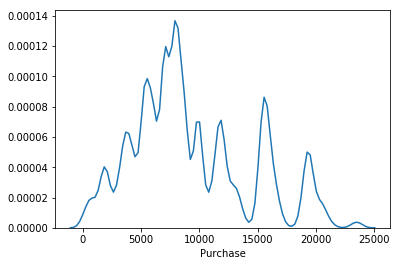

In [3]:
sns.distplot(train_df['Purchase'], hist=False)

### Multivariate

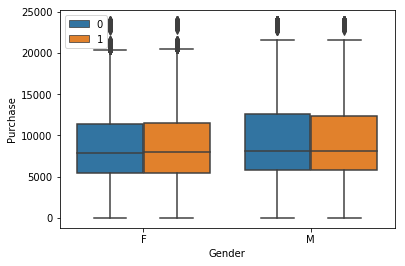

In [4]:
ax = sns.boxplot(x='Gender', y='Purchase', hue='Marital_Status', data=train_df)
ax.legend(loc='upper left')

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
128362,1001746,P00265242,M,26-35,4,C,1,1,5,8.0,NaN,8879
398927,1001389,P00265242,M,26-35,17,B,4+,1,5,8.0,NaN,8688
46335,1001138,P00265242,M,18-25,12,C,4+,0,5,8.0,NaN,8647
103635,1003982,P00265242,M,55+,13,C,2,0,5,8.0,NaN,5181
320796,1001413,P00265242,M,18-25,3,B,1,1,5,8.0,NaN,7032


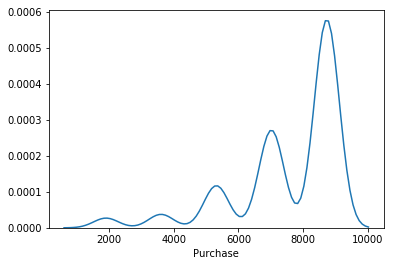

In [5]:
temp = train_df.loc[train_df['Product_ID'] == 'P00265242']
temp.sample(5)
sns.distplot(temp['Purchase'], hist=False)

### Encoding

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
User_ID                       550068 non-null int64
Product_ID                    550068 non-null object
Gender                        550068 non-null object
Age                           550068 non-null object
Occupation                    550068 non-null int64
City_Category                 550068 non-null object
Stay_In_Current_City_Years    550068 non-null object
Marital_Status                550068 non-null int64
Product_Category_1            550068 non-null int64
Product_Category_2            376430 non-null float64
Product_Category_3            166821 non-null float64
Purchase                      550068 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [7]:
train_df1 = train_df.copy();
test_df1 = test_df.copy();

le = LabelEncoder()
train_df1['User_ID'] = le.fit_transform(train_df['User_ID'])
train_df1['Product_ID'] = le.fit_transform(train_df['Product_ID'])
test_df1['User_ID'] = le.fit_transform(test_df['User_ID'])
test_df1['Product_ID'] = le.fit_transform(test_df['Product_ID'])

train_df1 = pd.get_dummies(train_df1)
test_df1 = pd.get_dummies(test_df1)

train_df1.info()
train_df1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 25 columns):
User_ID                          550068 non-null int64
Product_ID                       550068 non-null int64
Occupation                       550068 non-null int64
Marital_Status                   550068 non-null int64
Product_Category_1               550068 non-null int64
Product_Category_2               376430 non-null float64
Product_Category_3               166821 non-null float64
Purchase                         550068 non-null int64
Gender_F                         550068 non-null uint8
Gender_M                         550068 non-null uint8
Age_0-17                         550068 non-null uint8
Age_18-25                        550068 non-null uint8
Age_26-35                        550068 non-null uint8
Age_36-45                        550068 non-null uint8
Age_46-50                        550068 non-null uint8
Age_51-55                        550068 non-null uint8
Age_5

,User_ID,Product_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Gender_F,Gender_M,...,Age_51-55,Age_55+,City_Category_A,City_Category_B,City_Category_C,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+
0,0,672,10,0,3,NaN,NaN,8370,1,0,...,0,0,1,0,0,0,0,1,0,0
1,0,2376,10,0,1,6.0,14.0,15200,1,0,...,0,0,1,0,0,0,0,1,0,0
2,0,852,10,0,12,NaN,NaN,1422,1,0,...,0,0,1,0,0,0,0,1,0,0
3,0,828,10,0,12,14.0,NaN,1057,1,0,...,0,0,1,0,0,0,0,1,0,0
4,1,2734,16,0,8,NaN,NaN,7969,0,1,...,0,1,0,0,1,0,0,0,0,1


In [8]:
y_train = train_df1['Purchase']
x_train = train_df1.drop(['Purchase', 'Product_Category_2', 'Product_Category_3'], axis=1)

x_test = test_df1.drop(['Product_Category_2', 'Product_Category_3'], axis=1)

In [9]:
dtrain = xgb.DMatrix(x_train.values, label=y_train, missing=np.nan)
param = {'objective': 'reg:linear', 'booster': 'gbtree', 'silent': 1,
		 'max_depth': 10, 'eta': 0.1,
		 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 20,
		 'max_delta_step': 0, 'gamma': 0}
num_round = 600

In [10]:
seeds = [1122, 2244, 3366, 4488, 5500]
test_preds = np.zeros((len(x_test), len(seeds)))

for run in range(len(seeds)):
	sys.stdout.write("\rXGB RUN:{}/{}".format(run+1, len(seeds)))
	sys.stdout.flush()
	param['seed'] = seeds[run]
	clf = xgb.train(param, dtrain, num_round)
	dtest = xgb.DMatrix(x_test.values, missing=np.nan)
	test_preds[:, run] = clf.predict(dtest)

test_preds = np.mean(test_preds, axis=1)

XGB RUN:5/5

In [11]:
#lin = linear_model.LinearRegression()
# train the model on the training set
#lin.fit(x_train, y_train)
#lin_score_train = lin.score(x_train, y_train)
#test_df['Purchase'] = lin.predict(x_test)

In [12]:
test_df['Purchase'] = test_preds
test_df.to_csv("../output/final_solution.csv", index=False)